In [1]:
from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from highlight_text import HighlightText, ax_text, fig_text
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import matplotlib.patheffects as path_effects

In [2]:
data = pd.read_csv("T5_Leagues_2425.csv" , low_memory=False)
data['x'] = data['x']*1.2
data['y'] = data['y']*.8
data['endX'] = data['endX']*1.2
data['endY'] = data['endY']*.8

In [3]:
def add_carries(game_df):
   min_dribble_length: float = 0.0
   max_dribble_length: float = 100.0
   max_dribble_duration: float = 20.0
   game_df['time_seconds']=game_df['minute']*60+game_df['second']
   next_actions = data.shift(-1)
   same_game=game_df.gameId==next_actions.gameId
   same_team = game_df.teamId == next_actions.teamId
   dx = game_df.endX - next_actions.x
   dy = game_df.endY- next_actions.y
   far_enough=dy** 2 + dy** 2 >= min_dribble_length** 2
   not_too_far = dx ** 2+ dy** 2<= max_dribble_length ** 2
   dt = next_actions.time_seconds - game_df.time_seconds
   same_phase = dt < max_dribble_duration
   same_period = game_df.period == next_actions.period
   dribble_idx = same_team & far_enough & not_too_far & same_phase & same_period&same_game
   dribbles = pd.DataFrame()
   prev = game_df[dribble_idx]
   nex= next_actions[dribble_idx]
   dribbles['gameId' ] = nex.gameId
   dribbles['period' ] = nex.period
   for cols in ['expandedMinute']:
      dribbles[cols] = nex[cols]
   for cols in ['passKey','assist']:
      dribbles[ cols] = [True for _ in range (len (dribbles))]
   dribbles['isTouch'] = [True for _ in range (len (dribbles))]
   morecols = ['playerId', 'team','player']
   for cols in morecols:
      dribbles[cols] = nex[cols]
   #dribbles['action_id'] = prev.eventId + 0.1
   dribbles['time_seconds' ] = (prev.time_seconds + nex.time_seconds) / 2
   dribbles['teamId'] = nex.teamId
   dribbles['playerId']= nex.playerId
   dribbles['player' ]= nex.player
   dribbles['x'] = prev.endX
   dribbles['y']= prev.endY
   dribbles['endX'] = nex.x
   dribbles['endY'] = nex.y
   dribbles['type'] = ['Carry' for _ in range(len(dribbles))]
   dribbles['outcomeType'] = ['Successful' for _ in range(len(dribbles))]
   dribbles['qualifiers']=[{} for _ in range(len(dribbles))]
   game_df=pd.concat([game_df,dribbles], ignore_index=True,sort=False)
   game_df=game_df.sort_values(['gameId','period']).reset_index(drop=True)
   game_df['action_id']=range(len(game_df))
   return game_df

In [4]:
data = add_carries(data)

In [5]:
data_carries = data[data['type'] == 'Carry']

In [6]:
data_passes = data[(data['type'] == 'Pass') & (data['outcomeType'] == 'Successful') & (data['x'] <= 119.2)]

In [14]:

#For Left-Flank
x_min = 60
x_max = 120       # width = 18
y_min = 62
y_max = 80 

#For Right-Flank
#x_min = 60
#x_max = 120       # width = 18
#y_min = 0
#y_max = 18

# Add columns to identify half-space passes and carries


data_passes['in_left_flank'] = (data_passes['x'].between(x_min, x_max) & 
                          data_passes['y'].between(y_min, y_max))

data_carries['in_left_flank'] = (data_carries['x'].between(x_min, x_max) & 
                          data_carries['y'].between(y_min, y_max))

#data_passes['into_left_flank'] = (data_passes['endX'].between(x_min, x_max) & 
                          # data_passes['endY'].between(y_min, y_max) & 
                           #(data_passes['in_pen_box'] == False))

#data_carries['into_left_flank'] = (data_carries['endX'].between(x_min, x_max) & 
 #                          data_carries['endY'].between(y_min, y_max) & 
  #                         (data_carries['in_pen_box'] == False))


def calculate_progressive_actions(df):
    df_prog = df.copy()
    df_prog['beginning'] = np.sqrt(np.square(120 - df_prog['x']) + np.square(40 - df_prog['y']))
    df_prog['end'] = np.sqrt(np.square(120 - df_prog['endX']) + np.square(40 - df_prog['endY']))
    df_prog['progressive'] = (df_prog['end'] / df_prog['beginning']) < 0.75
    return df_prog[df_prog['progressive']]


# Filter data for passes and carries into half-spaces
left_flank_passes = calculate_progressive_actions(data_passes[data_passes['in_left_flank']])
left_flank_carries = calculate_progressive_actions(data_carries[data_carries['in_left_flank']])


# Group and aggregate
left_flank_passes_grouped = left_flank_passes.groupby(['playerId', 'player', 'team']).size().reset_index(name='left_flank_passes')
left_flank_carries_grouped = left_flank_carries.groupby(['playerId', 'player', 'team']).size().reset_index(name='left_flank_carries')


result_df_box = pd.merge(left_flank_passes_grouped, left_flank_carries_grouped, on=['playerId', 'player', 'team'], how='outer').fillna(0)
result_df_box['left_flank_actions'] = result_df_box['left_flank_passes'] + result_df_box['left_flank_carries']


info = pd.read_csv("T5_League_Mins_2025.csv")
info['90s'] = info['Mins'] / 90

result_df_box = pd.merge(result_df_box, info, on=['player', 'team'], how='left')
result_df_box['left_flank_actions_p90'] = result_df_box['left_flank_actions'] / result_df_box['90s']
#combined_prog_df['prog_lhs_actions_p90'] = combined_prog_df['prog_lhs_actions'] / combined_prog_df['90s']
result_df_box = result_df_box[(result_df_box['90s'] >= 15) & (result_df_box['position'] != 'GK')
                              
                                    
                                    
                                ]


result_df_box = result_df_box.drop_duplicates(subset=['player'])
top_12_box = result_df_box.sort_values("left_flank_actions_p90", ascending=False).head(12)

top_12_box




/var/folders/yd/kz4hmn8n5d102wb_dk7p1gf00000gn/T/ipykernel_64882/290465538.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_passes['in_left_flank'] = (data_passes['x'].between(x_min, x_max) &
/var/folders/yd/kz4hmn8n5d102wb_dk7p1gf00000gn/T/ipykernel_64882/290465538.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_carries['in_left_flank'] = (data_carries['x'].between(x_min, x_max) &


,playerId,player,team,left_flank_passes,left_flank_carries,left_flank_actions,Unnamed: 0,age,position,Mins,Passing Accuracy,90s,left_flank_actions_p90
1348,388098.0,Jérémy Doku,Man City,46.0,119.0,165.0,17.0,23.0,M(LR),1515.0,84.4,16.833333,9.801980
882,337782.0,Vinícius Júnior,Real Madrid,48.0,128.0,176.0,5.0,24.0,"AM(L),FW",2259.0,79.0,25.100000,7.011952
115,92329.0,Leonardo Spinazzola,Napoli,61.0,52.0,113.0,182.0,32.0,"D(LR),M(L)",1521.0,83.5,16.900000,6.686391
973,349888.0,Chris Führich,Stuttgart,73.0,74.0,147.0,303.0,27.0,"M(CLR),FW",1990.0,85.2,22.111111,6.648241
1730,425366.0,Bradley Barcola,PSG,60.0,97.0,157.0,5.0,22.0,"AM(LR),FW",2194.0,83.4,24.377778,6.440292
1859,438102.0,Malick Fofana,Lyon,34.0,79.0,113.0,316.0,20.0,M(L),1587.0,83.6,17.633333,6.408318
950,346300.0,Jadon Sancho,Chelsea,49.0,74.0,123.0,203.0,25.0,AM(CLR),1767.0,85.2,19.633333,6.264856
801,323352.0,Diego Rico,Getafe,174.0,2.0,176.0,90.0,32.0,"D(CL),M(L)",2820.0,69.4,31.333333,5.617021
112,91909.0,Son Heung-Min,Tottenham,63.0,63.0,126.0,33.0,32.0,"M(CLR),FW",2118.0,84.1,23.533333,5.354108
962,349207.0,Rafael Leão,AC Milan,54.0,82.0,136.0,20.0,25.0,"AM(CL),FW",2332.0,77.0,25.911111,5.248714


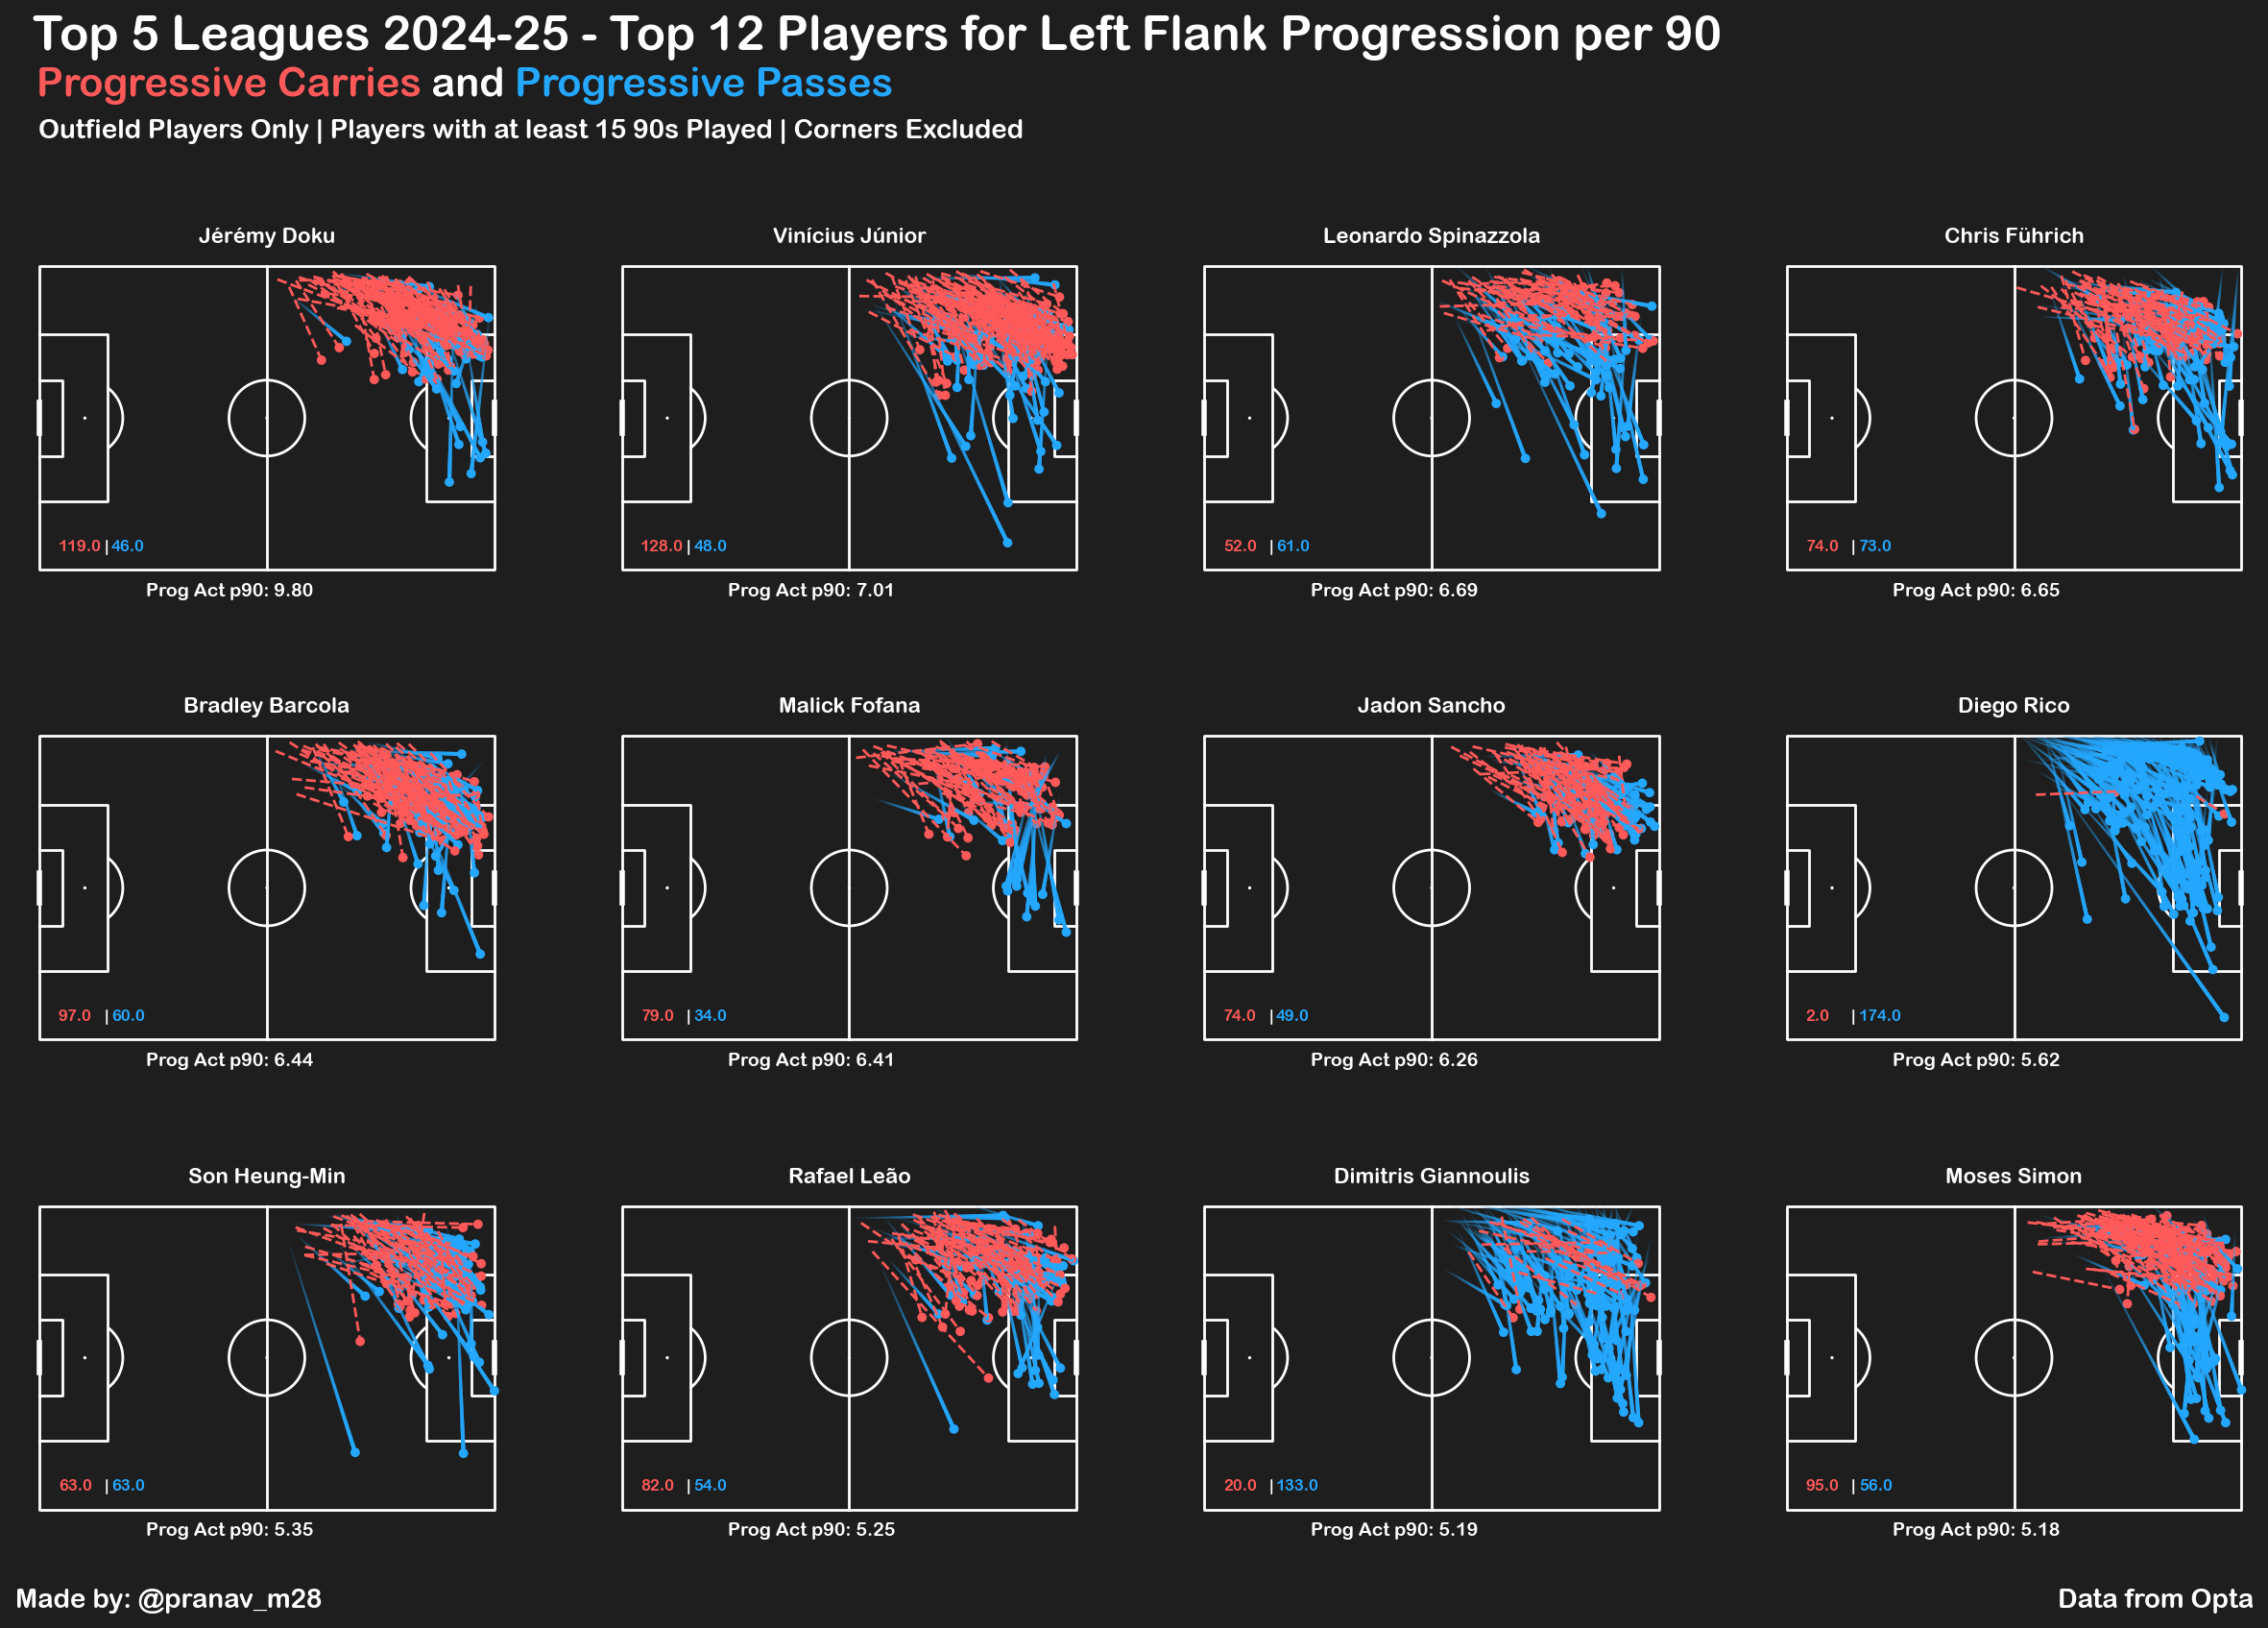

In [30]:
fig, axs = plt.subplots(3, 4, figsize=(30, 18))
fig.set_facecolor('#1e1e1e')

for ax, (_, player_data) in zip(axs.flatten(), top_12_box.iterrows()):
    player_id = player_data['playerId']
    player_name = player_data['player']
    left_flank_passes_count = player_data['left_flank_passes']
    left_flank_carries_count = player_data['left_flank_carries']
    left_flank_act_p90 = player_data['left_flank_actions_p90']
    
    player_passes = left_flank_passes[left_flank_passes['playerId'] == player_id]
    player_carries = left_flank_carries[left_flank_carries['playerId'] == player_id]
    
    pitch = Pitch(pitch_type='statsbomb', pitch_color='#1e1e1e', line_color='#FFFFFF')
    pitch.draw(ax=ax)
    
    # Plot RHS Passes
    pitch.lines(player_passes.x, player_passes.y, player_passes.endX, player_passes.endY,
                lw=3, transparent=True, comet=True, color='#24a8ff', ax=ax)
    pitch.scatter(player_passes.endX, player_passes.endY, s=50, marker='o', edgecolors='none', c='#24a8ff', ax=ax, alpha=1)
    
    # Plot RHS Carries
    pitch.lines(player_carries.x, player_carries.y, player_carries.endX, player_carries.endY, 
                ls='dashed', lw=2, transparent=False, comet=False, color='#FF5959', ax=ax)
    pitch.scatter(player_carries.endX, player_carries.endY, s=50, marker='o', edgecolors='none', c='#FF5959', ax=ax, alpha=1)
    
    ax.invert_yaxis()
    ax.set_title(f'{player_name}', font='Arial Rounded MT Bold', color='#FFFFFF', fontsize=16)
    
    ax.text(5, 5, f'{left_flank_carries_count}', color='#FF5959', font='Arial Rounded MT Bold', fontsize=12, ha='left')
    ax.text(17, 5, '|', color='#FFFFFF', font='Arial Rounded MT Bold', fontsize=12, ha='left')
    ax.text(19, 5, f'{left_flank_passes_count}', font='Arial Rounded MT Bold', color='#24A8FF', fontsize=12, ha='left')
    ax.text(28, -7, f'Prog Act p90: {left_flank_act_p90:.2f}', font='Arial Rounded MT Bold', color='#FFFFFF', fontsize=14, ha='left')

fig_text(0.421, 1.00, "Top 5 Leagues 2024-25 - Top 12 Players for Left Flank Progression per 90", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=36, fontweight='bold')
fig_text(0.278, 0.97, "<Progressive Carries> and <Progressive Passes>", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=30, fontweight='bold', highlight_textprops=[{"color": '#FF5959'}, {"color": '#24A8FF'}])
fig_text(0.301, 0.94, "Outfield Players Only | Players with at least 15 90s Played | Corners Excluded", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=20, fontweight='bold')


fig_text(0.175, 0.09, "Made by: @pranav_m28", ha="center", font='Arial Rounded MT Bold' ,color="#FFFFFF", fontsize=20, fontweight='bold')
fig_text(0.865, 0.09, "Data from Opta", ha="center", font='Arial Rounded MT Bold' ,color="#FFFFFF", fontsize=20, fontweight='bold')

#plt.savefig("T5_Left_Flank_2425.png" , dpi=300, bbox_inches='tight')
plt.show()